<a href="https://colab.research.google.com/github/SH22Hwang/KoGES_OP/blob/master/OP_20231113.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 골다공증

다양한 모델로 돌려보았다~

- Traditional ML
  + KNN
  + Decison Tree
  + SVM <- 공부 좀 해야할 듯
- GBDT
  + XGBoost
  + LGBM
- DNN
  + MLP

## 총 정리

- 각 데이터 별로 나눠서 돌리기
  - 대상
    - 폐경 전
    - 폐경 후
    - 모든 여성
  - Feature : 일단 하나만 진행
    - 식이패턴만
    - ~~유전체만~~
    - ~~둘 다~~

- 전처리 / 증강은 X_train만 할 것

- Normalization은 따로따로
  - train, val : fit
  - test : fit_transform

- catboost 도입

- imbalaced에 적합한 metric
  - f1 score
  - PR AUC
  - 사용하지 말 것
    - accuracy
    - ROC AUC

- SVM도 잘 만들어볼 것



In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as fn
from torch.utils.data import DataLoader, TensorDataset, Dataset

import sklearn
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, Normalizer, QuantileTransformer

from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score # 참고용
from sklearn.metrics import f1_score, precision_recall_curve # metric

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler # X_test... 사용 안 함.

from xgboost import XGBClassifier
import lightgbm as lgb

import numpy as np
import pandas as pd

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install category_encoders
import category_encoders as ce
sklearn.set_config(transform_output="pandas")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 1.9 MB/s eta 0:00:00


In [3]:
# 데이터 불러오기
# _all: 폐경 전 후 snp까지 모두

X_all = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dataset/X_231005.csv', index_col=0)
y_all = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dataset/y_231005.csv', index_col=0)

y_premeno = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/PreProcessed/y_premeno_20230821.csv', index_col=0)
y_postmeno = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/PreProcessed/y_postmeno_20230821.csv', index_col=0)

var_to_use = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/PreProcessed/var_to_use_2023-06-13T1650I.csv')

In [4]:
X_all.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4093 entries, NIH2307713334 to NIH2307534318
Columns: 140 entries, AS1_SEX to SNP_A-2242511
dtypes: float64(127), object(13)
memory usage: 4.4+ MB


## 데이터 전처리

- train set: 0.8
  - train set: 0.64
  - val set: 0.16
- test set: 0.2

[참고 자료](https://ysyblog.tistory.com/69)


- 데이터셋 만들 수 있는 경우의 수 총 9개
  1. 폐경 전 / 식이패턴 있음, 유전체 없음
  2. 폐경 후 / 식이패턴 있음, 유전체 없음
  3. 모두 / 식이패턴 있음, 유전체 없음
  4. 폐경 전 / 식이패턴 없음, 유전체 있음
  5. 폐경 후 / 식이패턴 없음, 유전체 있음
  6. 모두 / 식이패턴 없음, 유전체 있음
  7. 폐경 전 / 식이패턴 있음, 유전체 있음
  8. 폐경 후 / 식이패턴 있음, 유전체 있음
  9. 모두 / 식이패턴 있음, 유전체 있음

### 통계적 수치 측정

In [5]:
# Statistical Accuracy Measurement Comprehensive Gift Set
def SAMCGS(y_test, y_pred):
  # 정확도 종합 선물 세트
  accuracy = accuracy_score(y_test, y_pred)
  conf_mat = confusion_matrix(y_test, y_pred)
  # [[TP  FN]
  # [ FP  TN]]

  precision = precision_score(y_test, y_pred, zero_division=1) # tp / (tp + fp)
  recall = recall_score(y_test, y_pred, zero_division=1)       # tp / (tp + fn)
  f1 = f1_score(y_test, y_pred, zero_division=1) # 2 * (precision * recall) / (precision + recall)

  print(f''' Confusion Matrix:\n{conf_mat}\n
  [[TP  FN]
  [ FP  TN]]

  Accuracy: {accuracy:.3f}
  Precison: {precision:.3f}
  Recall  : {recall:.3f}
  F1 Score: {f1:.3f}'''
  )

  # return precision, recall, f1

In [6]:
quantile_transformer = QuantileTransformer(random_state=415)
norm = Normalizer()

# Define catboost encoder
cbe_encoder = ce.cat_boost.CatBoostEncoder()

smt = SMOTE(random_state=415)
rus = RandomUnderSampler(random_state=415)

In [7]:
# 9가지 경우의 수에 맞게 데이터 돌림

meno1 = X_all['AS1_PMYN_C'] == 1
meno2 = X_all['AS1_PMYN_C'] == 2
snp = pd.Series(['SNP_A-2181021', 'SNP_A-1809518', 'SNP_A-2130710', 'SNP_A-2263153',
                 'SNP_A-2310995', 'SNP_A-1922415', 'SNP_A-2266073', 'SNP_A-1984271',
                 'SNP_A-2218697', 'SNP_A-1850320', 'SNP_A-4262878', 'SNP_A-4299800',
                 'SNP_A-2242511'])

onehot = pd.concat([var_to_use['cath0'].dropna(), snp], ignore_index=True)

# 유전체 없이 var_to_use['cath0'].dropna() 만으로는 float밖에 없어서 astype으로 str로 변경
cath0_dict = {k: 'str' for k in var_to_use['cath0'].dropna().unique()}
cath0_snp_dict = {k: 'str' for k in onehot.unique()}

In [8]:
cath0_snp_dict

{'AS1_EDUA': 'str',
 'AS1_DRINK': 'str',
 'AS1_SMOKEA': 'str',
 'AS1_FMOSREL_N': 'str',
 'AS1_FMOSREL_O': 'str',
 'AS1_FMOSREL_P': 'str',
 'AS1_FMOSREL_S': 'str',
 'AS1_HYSTOVARYW': 'str',
 'AS1_OVARYW': 'str',
 'SNP_A-2181021': 'str',
 'SNP_A-1809518': 'str',
 'SNP_A-2130710': 'str',
 'SNP_A-2263153': 'str',
 'SNP_A-2310995': 'str',
 'SNP_A-1922415': 'str',
 'SNP_A-2266073': 'str',
 'SNP_A-1984271': 'str',
 'SNP_A-2218697': 'str',
 'SNP_A-1850320': 'str',
 'SNP_A-4262878': 'str',
 'SNP_A-4299800': 'str',
 'SNP_A-2242511': 'str'}

### Split 클래스

- x_train만 증강 후 xgboost : 자료 삭제
  - 최소: 0.3
  - 최대: 0.34782608695652173
  - 평균: 0.3262824444034863

- 전체 증강 후 xgboost
  > Confusion Matrix:
  >
  > [[292 77]
  >
  >  [ 89 281]]
  >
  >  [[TP FN]
  >
  >  [ FP TN]]
  >
  >  Accuracy: 0.775
  >
  >  Precison: 0.785
  >
  >  Recall : 0.759
  >
  >  F1 Score: 0.772


  왜 x_train만 증강하면 성능이 나쁠까? 왜 전체데이터를 증강하면 성능이 좋을까?

In [9]:
# class화
class Split:
  def __init__(self, x, y):
    self.norm = Normalizer()

    # train / test split 후 정규화, 증강
    # self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=415)

    # self.x_train = self.norm.fit_transform(self.x_train).astype('float') # norm 학습 train normalize
    # self.x_test = self.norm.transform(self.x_test).astype('float')       # test normalize
    # self.x_train, self.y_train = smt.fit_resample(self.x_train, self.y_train) # train 증강
    # self.x_test, self.y_test = smt.fit_resample(self.x_test, self.y_test) # test 증강

    # 전체 정규화, 증강 후 split
    x = self.norm.fit_transform(x).astype('float')
    x, y = smt.fit_resample(x, y)

    self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=415)


  def tt(self):
    return self.x_train, self.x_test, self.y_train, self.y_test

  def ttv(self):
    self.x_train, self.x_val, self.y_train, self.y_val = train_test_split(self.x_train, self.y_train, test_size=0.2, stratify=self.y_train, random_state=415)
    return self.x_train, self.x_test, self.x_val, self.y_train, self.y_test, self.y_val




# def split_ttv(x, y):
#   x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=415) # stratify: target의 class비율에 맞춰서 분리
#   x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, stratify=y_train, random_state=415) # stratify: target의 class비율에 맞춰서 분리
#   # 다른 걸로 바꿔보기..?
#   x_train = pd.DataFrame(norm.fit_transform(x_train).astype('float'))
#   x_test = pd.DataFrame(norm.transform(x_test).astype('float'))
#   x_val = pd.DataFrame(norm.transform(x_val).astype('float'))

#   # train 증강, test, val 컷
#   x_train, y_train = smt.fit_resample(x_train, y_train)
#   # x_test, y_test = rus.fit_resample(x_test, y_test)
#   # x_val, y_val = rus.fit_resample(x_val, y_val)

#   return x_train, x_test, x_val, y_train, y_test, y_val

# def split_tt(x, y):
#   # train : test == 4 : 1
#   x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=415) # stratify: target의 class비율에 맞춰서 분리

#   # 각각 하기?
#   # x_train = pd.DataFrame(quantile_transformer.fit_transform(x_train), index=x_train.index, columns=x_train.columns).astype('float')
#   # x_test = pd.DataFrame(quantile_transformer.transform(x_test), index=x_test.index, columns=x_test.columns).astype('float')

#   # 다른 걸로 바꿔보기..?
#   x_train = pd.DataFrame(norm.fit_transform(x_train).astype('float'))
#   x_test = pd.DataFrame(norm.transform(x_test).astype('float'))

#   # train 증강, test 컷
#   x_train, y_train = smt.fit_resample(x_train, y_train)
#   # x_test, y_test = rus.fit_resample(x_test, y_test)

#   return x_train, x_test, y_train, y_test

### Creating train/test/val split with StratifiedKFold

출처: https://stackoverflow.com/questions/45221940/creating-train-test-val-split-with-stratifiedkfold

In [10]:
from sklearn.model_selection import StratifiedKFold, train_test_split

class StratifiedKFold3(StratifiedKFold):
    def split(self, X, y, groups=None):
        s = super().split(X, y, groups)
        for train_indxs, test_indxs in s:
            y_train = y[train_indxs]
            train_indxs, cv_indxs = train_test_split(train_indxs,stratify=y_train, test_size=(1 / (self.n_splits - 1)))
            yield train_indxs, cv_indxs, test_indxs

In [11]:
# 1. 폐경 전 / 식이패턴 있음, 유전체 없음
# x = X_all.drop(snp, axis=1)
# x = pd.get_dummies(x.loc[meno1], columns=var_to_use['cath0'].dropna(), drop_first=True, dtype='float64')
# y = y_premeno
# f1score 거의 0

# 2. 폐경 후 / 식이패턴 있음, 유전체 없음
# x = X_all.loc[meno2].drop(snp, axis=1).astype(cath0_dict)
# y = y_postmeno

# # Fit encoder and transform the features
# cbe_encoder.fit(x, y)
# x = cbe_encoder.transform(x)

# 3. 모두 / 식이패턴 있음, 유전체 없음
# x = X_all.drop(snp, axis=1)
# x = pd.get_dummies(X_all, columns=onehot, drop_first=True, dtype='float64')
# y = y_all

# 4, 5, 6 생략

# 7. 폐경 전 / 식이패턴 있음, 유전체 있음
# x = pd.get_dummies(X_all.loc[meno1], columns=onehot, drop_first=True, dtype='float64')
# y = y_premeno
# f1score 거의 0

# # 8 폐경 후 / 식이패턴 있음, 유전체 있음
x = X_all.loc[meno2].astype(cath0_snp_dict)
y = y_postmeno
cbe_encoder.fit(x, y)
x = cbe_encoder.transform(x)
#### 정확도 매우 떨어짐

# # 9 모두 / 식이패턴 없음, 유전체 있음
# x = pd.get_dummies(X_all, columns=onehot, drop_first=True, dtype='float64')
# y = y_all

In [12]:
pd.set_option('display.max_seq_items', None)
# x.loc[:, var_to_use['cath0'].dropna().unique()]
x.loc[:, onehot.dropna().unique()]

,AS1_EDUA,AS1_DRINK,AS1_SMOKEA,AS1_FMOSREL_N,AS1_FMOSREL_O,AS1_FMOSREL_P,AS1_FMOSREL_S,AS1_HYSTOVARYW,AS1_OVARYW,SNP_A-2181021,...,SNP_A-2263153,SNP_A-2310995,SNP_A-1922415,SNP_A-2266073,SNP_A-1984271,SNP_A-2218697,SNP_A-1850320,SNP_A-4262878,SNP_A-4299800,SNP_A-2242511
NIH2307137554,0.344917,0.294051,0.280428,0.280873,0.280873,0.285883,0.280173,0.287635,0.282889,0.271362,...,0.284524,0.327304,0.316469,0.286146,0.276973,0.273562,0.274519,0.282510,0.282860,0.282456
NIH2307649667,0.180924,0.234805,0.280428,0.280873,0.280873,0.285883,0.280173,0.287635,0.282889,0.316630,...,0.284524,0.255167,0.278391,0.286146,0.285707,0.284207,0.287136,0.282510,0.282860,0.282456
NIH2307899915,0.180924,0.294051,0.280428,0.280873,0.280873,0.071348,0.280173,0.287635,0.282889,0.271362,...,0.284524,0.255167,0.278391,0.286146,0.285707,0.273562,0.287136,0.267238,0.282860,0.282456
NIH2307202612,0.180924,0.294051,0.280428,0.280873,0.280873,0.285883,0.280173,0.287635,0.282889,0.271362,...,0.284524,0.255167,0.278391,0.286146,0.283900,0.284207,0.287136,0.267238,0.282860,0.282456
NIH2307895121,0.344917,0.294051,0.280428,0.280873,0.280873,0.285883,0.280173,0.287635,0.282889,0.271362,...,0.284524,0.255167,0.316469,0.286146,0.283900,0.284207,0.287136,0.267238,0.282860,0.282456
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NIH2307635277,0.344917,0.234805,0.283542,0.280873,0.280873,0.285883,0.280173,0.287635,0.282889,0.316630,...,0.284524,0.327304,0.278391,0.286146,0.276973,0.284207,0.274519,0.267238,0.282860,0.282456
NIH2307591031,0.344917,0.294051,0.280428,0.280873,0.280873,0.285883,0.280173,0.287635,0.282889,0.271362,...,0.284524,0.255167,0.278391,0.286146,0.276973,0.273562,0.274519,0.282510,0.282860,0.282456
NIH2307808901,0.180924,0.294051,0.280428,0.280873,0.280873,0.285883,0.280173,0.212847,0.282889,0.316630,...,0.284524,0.255167,0.278391,0.286146,0.276973,0.273562,0.287136,0.267238,0.263202,0.266206
NIH2307930134,0.344917,0.294051,0.280428,0.280873,0.280873,0.285883,0.280173,0.287635,0.282889,0.316630,...,0.284524,0.327304,0.278391,0.260827,0.285707,0.310536,0.287136,0.282510,0.263202,0.266206


In [ ]:
x.head()

,AS1_SEX,AS1_HT,AS1_DM,AS1_AL,AS1_MI,AS1_TH,AS1_CH,AS1_CD,AS1_LP,AS1_AS,...,SNP_A-2263153,SNP_A-2310995,SNP_A-1922415,SNP_A-2266073,SNP_A-1984271,SNP_A-2218697,SNP_A-1850320,SNP_A-4262878,SNP_A-4299800,SNP_A-2242511
NIH2307137554,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.284524,0.327304,0.316469,0.286146,0.276973,0.273562,0.274519,0.282510,0.28286,0.282456
NIH2307649667,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.284524,0.255167,0.278391,0.286146,0.285707,0.284207,0.287136,0.282510,0.28286,0.282456
NIH2307899915,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.284524,0.255167,0.278391,0.286146,0.285707,0.273562,0.287136,0.267238,0.28286,0.282456
NIH2307202612,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.284524,0.255167,0.278391,0.286146,0.283900,0.284207,0.287136,0.267238,0.28286,0.282456
NIH2307895121,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.284524,0.255167,0.316469,0.286146,0.283900,0.284207,0.287136,0.267238,0.28286,0.282456


## Decision Tree

In [ ]:
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
import graphviz

In [ ]:
scores = []
# Defining the hyper parameters
hps = {
    'max_depth': 5,
    'min_samples_split': 2
}
# Loading the tree object
tree = DecisionTreeClassifier(**hps)

str_kf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 415)
# kf3 = StratifiedKFold3(n_splits = 5, shuffle = True, random_state = 415)

# split 개수 스텝 만큼 train, test 데이터셋을 매번 분할
for i, indexes in enumerate(str_kf.split(x, y), start=1):
  train_index = indexes[0]
  test_index = indexes[1]


  X_train = x.iloc[train_index]
  X_test = x.iloc[test_index]
  y_train = y.iloc[train_index]
  y_test = y.iloc[test_index]

  X_train, y_train = smt.fit_resample(X_train, y_train)

  tree.fit(X_train, y_train)

  y_pred = tree.predict(X_test)

  print(f"iter:{i}")
  SAMCGS(y_test, y_pred)

  scores.append(round(f1_score(y_test, y_pred, zero_division=1), 4))

print(f''' scores
최소: {min(scores)}
최대: {max(scores)}
평균: {np.mean(scores)}
''')

iter:1
 Confusion Matrix:
[[304  66]
 [101  43]]

  [[TP  FN]
  [ FP  TN]]

  Accuracy: 0.675
  Precison: 0.394
  Recall  : 0.299
  F1 Score: 0.340
iter:2
 Confusion Matrix:
[[285  84]
 [ 97  48]]

  [[TP  FN]
  [ FP  TN]]

  Accuracy: 0.648
  Precison: 0.364
  Recall  : 0.331
  F1 Score: 0.347
iter:3
 Confusion Matrix:
[[305  64]
 [ 85  59]]

  [[TP  FN]
  [ FP  TN]]

  Accuracy: 0.710
  Precison: 0.480
  Recall  : 0.410
  F1 Score: 0.442
iter:4
 Confusion Matrix:
[[265 104]
 [ 78  66]]

  [[TP  FN]
  [ FP  TN]]

  Accuracy: 0.645
  Precison: 0.388
  Recall  : 0.458
  F1 Score: 0.420
iter:5
 Confusion Matrix:
[[233 136]
 [ 68  76]]

  [[TP  FN]
  [ FP  TN]]

  Accuracy: 0.602
  Precison: 0.358
  Recall  : 0.528
  F1 Score: 0.427
 scores
최소: 0.3399
최대: 0.4419
평균: 0.39516



### 그래프

In [ ]:
# Defining the hyper parameters
hps = {
    'max_depth': 5,
    'min_samples_split': 4
}

# Loading the tree object
tree = DecisionTreeClassifier(**hps)

tree.fit(x, y)

DecisionTreeClassifier(max_depth=5, min_samples_split=4)

In [ ]:
export_graphviz(tree, out_file="tree.dot",
                class_names='FT',
                feature_names=x.columns,
                impurity=True, filled=True)

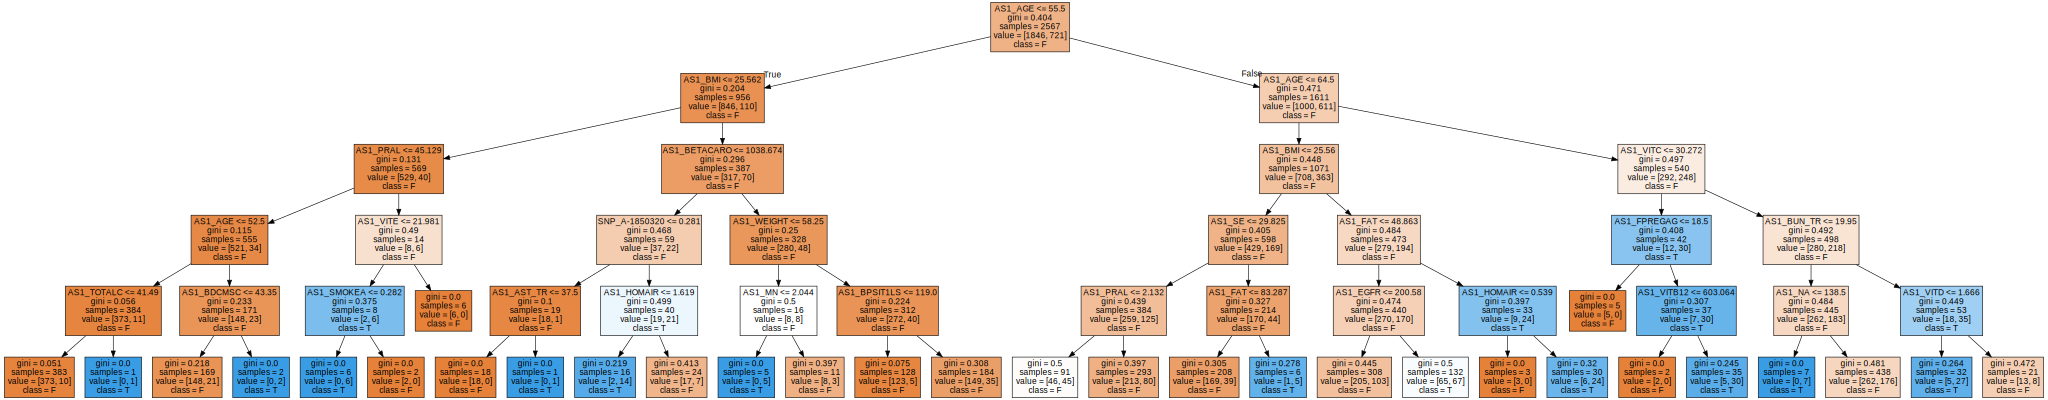

In [ ]:
with open("tree.dot") as f:
    dot_graph = f.read()

graphviz.Source(dot_graph, filename='tree.png',format='png')

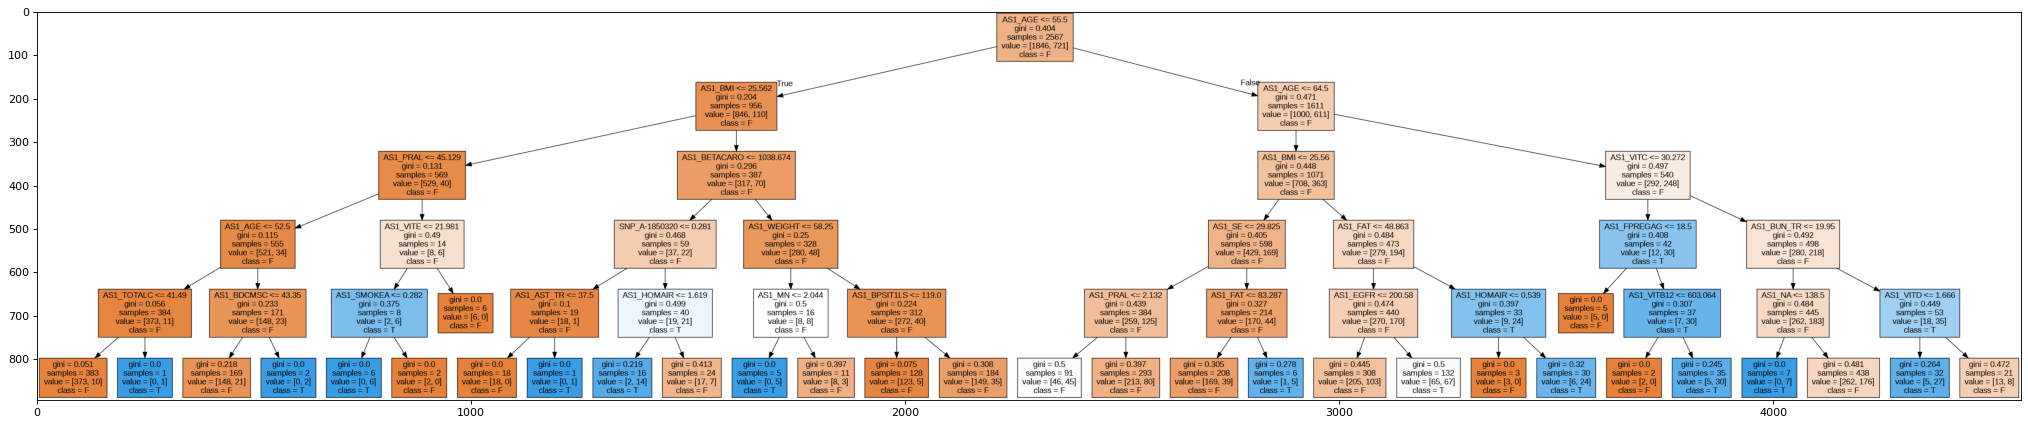

In [ ]:
!dot -Tpng tree.dot -o tree.png

tree_img = plt.imread('./tree.png')

plt.figure(num=None, figsize=(32, 9), dpi=80, facecolor='w', edgecolor='k')
plt.imshow(tree_img)

### importance

In [ ]:
# Extracting the importances by sklearn
importances_sk = tree.feature_importances_

# Creating a dataframe with the feature importance by sklearn
feature_importance_sk = {}
for i, feature in enumerate(X_test.columns.tolist()):
    feature_importance_sk[feature] = round(importances_sk[i], 3)

print(f"Feature importance by sklearn: {feature_importance_sk}")

Feature importance by sklearn: {'AS1_SEX': 0.0, 'AS1_HT': 0.0, 'AS1_DM': 0.0, 'AS1_AL': 0.0, 'AS1_MI': 0.0, 'AS1_TH': 0.0, 'AS1_CH': 0.0, 'AS1_CD': 0.0, 'AS1_LP': 0.0, 'AS1_AS': 0.0, 'AS1_CL': 0.0, 'AS1_KD': 0.0, 'AS1_CV': 0.0, 'AS1_GT': 0.0, 'AS1_ARRM': 0.0, 'AS1_DRST': 0.0, 'AS1_DRCP': 0.0, 'AS1_DRINS': 0.0, 'AS1_DRHT': 0.0, 'AS1_DRAR': 0.0, 'AS1_DRTH': 0.0, 'AS1_DRFH': 0.0, 'AS1_DROS': 0.0, 'AS1_DRSTK': 0.0, 'AS1_DRAS': 0.0, 'AS1_DRLP': 0.0, 'AS1_DRSP': 0.0, 'AS1_DRSL': 0.0, 'AS1_PMYN_C': 0.0, 'AS1_PREG': 0.0, 'AS1_HYST': 0.0, 'AS1_OBGYOP': 0.0, 'AS1_BRCA': 0.0, 'AS1_BRSTF': 0.0, 'AS1_INSM': 0.0, 'AS1_SLPHRD': 0.0, 'AS1_EDUA': 0.0, 'AS1_DRINK': 0.0, 'AS1_SMOKEA': 0.014, 'AS1_FMOSREL_N': 0.0, 'AS1_FMOSREL_O': 0.0, 'AS1_FMOSREL_P': 0.0, 'AS1_FMOSREL_S': 0.0, 'AS1_HYSTOVARYW': 0.0, 'AS1_OVARYW': 0.0, 'AS1_INCOME': 0.0, 'AS1_PHYSTB': 0.0, 'AS1_PHYSIT': 0.0, 'AS1_PHYACTL': 0.0, 'AS1_PHYACTM': 0.0, 'AS1_PHYACTH': 0.0, 'AS1_ICOFF_1': 0.0, 'AS1_AGE': 0.441, 'AS1_TOTALC': 0.009, 'AS1_PMAG_C'

Text(0, 0.5, 'feature importance')

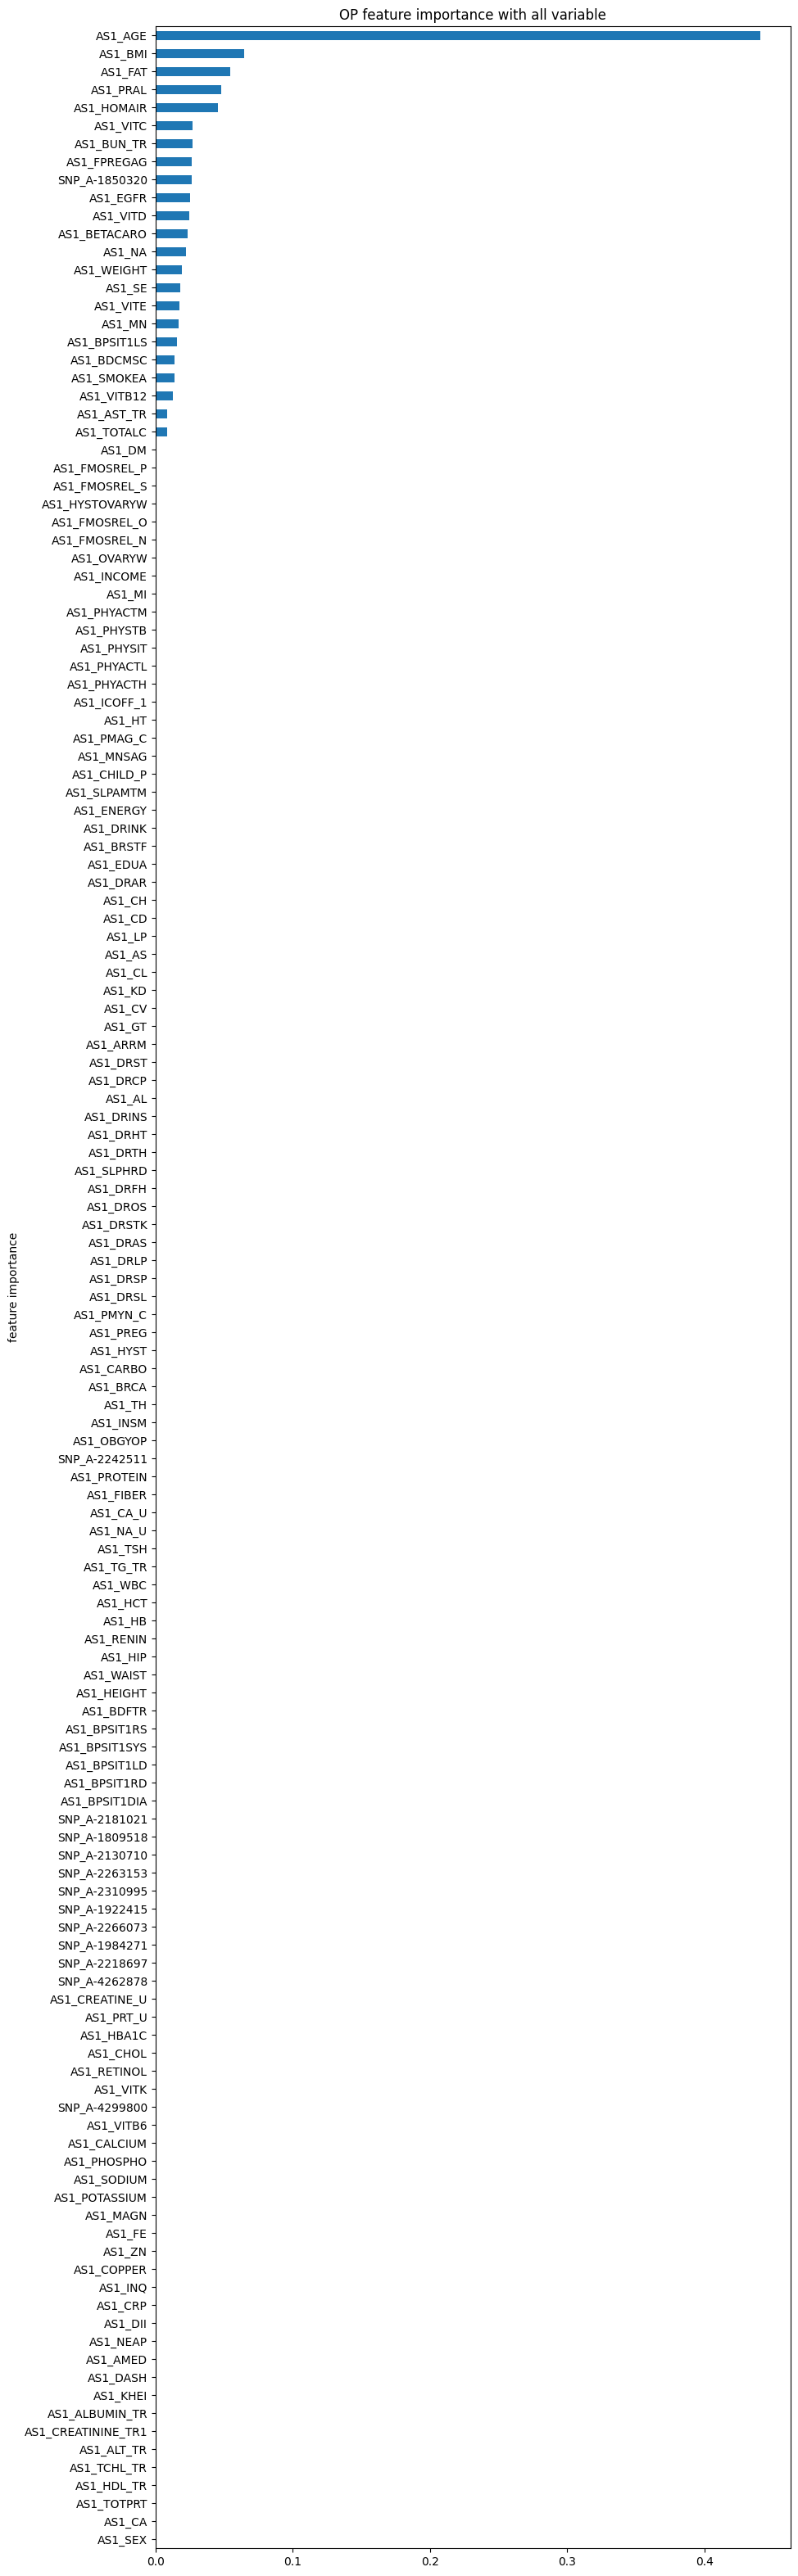

In [ ]:
importances = tree.feature_importances_

tree_importances = pd.Series(importances, index=X_test.columns).sort_values()
fig, ax = plt.subplots(figsize=(10, 40))
tree_importances.plot.barh(ax=ax)
ax.set_title("OP feature importance with all variable")
ax.set_ylabel("feature importance")

In [ ]:
tree_importances

AS1_SEX        0.000000
AS1_CA         0.000000
AS1_TOTPRT     0.000000
AS1_HDL_TR     0.000000
AS1_TCHL_TR    0.000000
                 ...   
AS1_HOMAIR     0.045641
AS1_PRAL       0.047789
AS1_FAT        0.054638
AS1_BMI        0.064767
AS1_AGE        0.440768
Length: 140, dtype: float64

## KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=2)
# knn.fit(X_train, y_train)

# y_pred = knn.predict(X_test)

In [ ]:
scores = []

str_kf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 415)

# split 개수 스텝 만큼 train, test 데이터셋을 매번 분할
for i, indexes in enumerate(str_kf.split(x, y), start=1):
  train_index = indexes[0]
  test_index = indexes[1]

  X_train = x.iloc[train_index]
  X_test = x.iloc[test_index]
  y_train = y.iloc[train_index]
  y_test = y.iloc[test_index]

  X_train, y_train = smt.fit_resample(X_train, y_train)

  knn.fit(X_train, y_train)

  y_pred = knn.predict(X_test)

  print(f"iter:{i}")
  SAMCGS(y_test, y_pred)

  scores.append(round(f1_score(y_test, y_pred, zero_division=1), 4))

print(f''' scores
최소: {min(scores)}
최대: {max(scores)}
평균: {np.mean(scores)}
''')

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


iter:1
 Confusion Matrix:
[[266 104]
 [112  32]]

  [[TP  FN]
  [ FP  TN]]

  Accuracy: 0.580
  Precison: 0.235
  Recall  : 0.222
  F1 Score: 0.229


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


iter:2
 Confusion Matrix:
[[290  79]
 [105  40]]

  [[TP  FN]
  [ FP  TN]]

  Accuracy: 0.642
  Precison: 0.336
  Recall  : 0.276
  F1 Score: 0.303


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


iter:3
 Confusion Matrix:
[[281  88]
 [ 99  45]]

  [[TP  FN]
  [ FP  TN]]

  Accuracy: 0.635
  Precison: 0.338
  Recall  : 0.312
  F1 Score: 0.325


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


iter:4
 Confusion Matrix:
[[273  96]
 [107  37]]

  [[TP  FN]
  [ FP  TN]]

  Accuracy: 0.604
  Precison: 0.278
  Recall  : 0.257
  F1 Score: 0.267
iter:5
 Confusion Matrix:
[[280  89]
 [107  37]]

  [[TP  FN]
  [ FP  TN]]

  Accuracy: 0.618
  Precison: 0.294
  Recall  : 0.257
  F1 Score: 0.274
 scores
최소: 0.2286
최대: 0.3249
평균: 0.27954



/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


## SVM

In [ ]:
# Define the linear SVM model
class SVM(nn.Module):
    def __init__(self, input_dim):
        super(SVM, self).__init__()
        self.fc1 = nn.Linear(input_dim, 1)

    def forward(self, x):
        x = self.fc1(x)
        return x

In [ ]:
scores = []

# split 개수 스텝 만큼 train, test 데이터셋을 매번 분할
str_kf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 415)

for i, indexes in enumerate(str_kf.split(x, y), start=1):
  train_index = indexes[0]
  test_index = indexes[1]

  X_train = x.iloc[train_index]
  X_test = x.iloc[test_index]
  y_train = y.iloc[train_index]
  y_test = y.iloc[test_index]

  X_train = norm.fit_transform(X_train).astype('float') # norm 학습 train normalize
  X_test = norm.transform(X_test).astype('float')       # test normalize
  X_train, y_train = smt.fit_resample(X_train, y_train)

  X_train_tensor = torch.tensor(X_train.values).float()
  X_test_tensor = torch.tensor(X_test.values).float()
  y_train_tensor = torch.tensor(y_train.values).float()
  y_test_tensor = torch.tensor(y_test.values).float()

  svm = SVM(X_train.shape[1])

  # Define the loss function and optimizer
  criterion = nn.HingeEmbeddingLoss()
  optimizer = optim.SGD(svm.parameters(), lr=0.01)

   # Train the model
  for epoch in range(100):
      output = svm(X_train_tensor)

      loss = criterion(output, 2 * y_train_tensor.float()-1)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

  # Make predictions on the test set
  y_pred = torch.sign(svm(X_test_tensor).squeeze()).detach().numpy()
  y_pred = np.where(y_pred < 0, 0, 1)

  print(f"iter:{i}")
  SAMCGS(y_test, y_pred)

  scores.append(round(f1_score(y_test, y_pred, zero_division=1), 4))

print(f''' scores
최소: {min(scores)}
최대: {max(scores)}
평균: {np.mean(scores)}
''')

iter:1
 Confusion Matrix:
[[333  37]
 [120  24]]

  [[TP  FN]
  [ FP  TN]]

  Accuracy: 0.695
  Precison: 0.393
  Recall  : 0.167
  F1 Score: 0.234
iter:2
 Confusion Matrix:
[[196 173]
 [ 75  70]]

  [[TP  FN]
  [ FP  TN]]

  Accuracy: 0.518
  Precison: 0.288
  Recall  : 0.483
  F1 Score: 0.361
iter:3
 Confusion Matrix:
[[353  16]
 [134  10]]

  [[TP  FN]
  [ FP  TN]]

  Accuracy: 0.708
  Precison: 0.385
  Recall  : 0.069
  F1 Score: 0.118
iter:4
 Confusion Matrix:
[[344  25]
 [131  13]]

  [[TP  FN]
  [ FP  TN]]

  Accuracy: 0.696
  Precison: 0.342
  Recall  : 0.090
  F1 Score: 0.143
iter:5
 Confusion Matrix:
[[350  19]
 [134  10]]

  [[TP  FN]
  [ FP  TN]]

  Accuracy: 0.702
  Precison: 0.345
  Recall  : 0.069
  F1 Score: 0.116
 scores
최소: 0.1156
최대: 0.3608
평균: 0.1942



## XGBoost

In [ ]:
# from sklearn.model_selection import GridSearchCV

# # create model instance
# xgb = XGBClassifier(n_estimators=1000, # 나무의 개수
#                     learning_rate=0.01,
#                     # early_stopping_rounds=30,
#                     objective='binary:logistic',
#                     # eval_metric='aucpr', # auc -> aucpr
#                     # eval_set=[(X_val, y_val)],
#                     silent=0)

# # 후보 파라미터 선정
# params = {'max_depth':[3, 8], 'min_child_weight':[1, 3], 'colsample_bytree':[0,1]}

# # gridsearchcv 객체 정보 입력(어떤 모델, 파라미터 후보, 교차검증 몇 번)
# gridcv = GridSearchCV(xgb, param_grid=params, cv=5)

In [ ]:
# scores = []
# str_kf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 415)

# # split 개수 스텝 만큼 train, test 데이터셋을 매번 분할
# for i, indexes in enumerate(str_kf.split(x, y), start=1):
#   train_index = indexes[0]
#   test_index = indexes[1]

#   X_train = x.iloc[train_index]
#   X_test = x.iloc[test_index]
#   y_train = y.iloc[train_index]
#   y_test = y.iloc[test_index]

#   X_train = norm.fit_transform(X_train).astype('float') # norm 학습 train normalize
#   X_test = norm.transform(X_test).astype('float')       # test normalize
#   X_train, y_train = smt.fit_resample(X_train, y_train)

#   X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, stratify=y_train, random_state=415)

#   X_train_tensor = torch.tensor(X_train.values).float()
#   X_test_tensor = torch.tensor(X_test.values).float()
#   X_val_tensor = torch.tensor(X_val.values).float()
#   y_train_tensor = torch.tensor(y_train.values).float()
#   y_test_tensor = torch.tensor(y_test.values).float()
#   y_val_tensor = torch.tensor(y_val.values).float()

#   gridcv.fit(X_train, y_train,
#             early_stopping_rounds=30,
#             eval_metric='aucpr', # auc -> aucpr
#             eval_set=[(X_val, y_val)])

#   model = gridcv.best_estimator_
#   y_pred = model.predict(X_test)

#   print(f"iter:{i}")
#   SAMCGS(y_test, y_pred)

#   scores.append(f1_score(y_test, y_pred, zero_division=1))

In [13]:
X_train, X_test, X_val, y_train, y_test, y_val = Split(x,y).ttv()

In [31]:
# create model instance
xgb = XGBClassifier(n_estimators=1000, # 나무의 개수
                    learning_rate=0.01,
                    early_stopping_rounds=20,
                    # objective='binary:logistic',
                    max_depth=8,
                    colsample_bytree=1,
                    min_child_weight=1)

# 후보 파라미터 선정
# params = {'max_depth':[3, 8], 'min_child_weight':[1, 3], 'colsample_bytree':[0,1]}

# gridsearchcv 객체 정보 입력(어떤 모델, 파라미터 후보, 교차검증 몇 번)
# gridcv = GridSearchCV(xgb, param_grid=params, cv=5)

In [32]:
xgb.fit(X_train, y_train, eval_metric='aucpr', # auc -> aucpr
                    eval_set=[(X_val, y_val)],)

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-aucpr:0.75199
[1]	validation_0-aucpr:0.76977
[2]	validation_0-aucpr:0.76983
[3]	validation_0-aucpr:0.77095
[4]	validation_0-aucpr:0.77164
[5]	validation_0-aucpr:0.77481
[6]	validation_0-aucpr:0.78005
[7]	validation_0-aucpr:0.78465
[8]	validation_0-aucpr:0.78557
[9]	validation_0-aucpr:0.78292
[10]	validation_0-aucpr:0.78298
[11]	validation_0-aucpr:0.78391
[12]	validation_0-aucpr:0.78485
[13]	validation_0-aucpr:0.78581
[14]	validation_0-aucpr:0.78544
[15]	validation_0-aucpr:0.78547
[16]	validation_0-aucpr:0.78629
[17]	validation_0-aucpr:0.78604
[18]	validation_0-aucpr:0.78673
[19]	validation_0-aucpr:0.78635
[20]	validation_0-aucpr:0.78744
[21]	validation_0-aucpr:0.79015
[22]	validation_0-aucpr:0.79220
[23]	validation_0-aucpr:0.79342
[24]	validation_0-aucpr:0.79481
[25]	validation_0-aucpr:0.79709
[26]	validation_0-aucpr:0.79871
[27]	validation_0-aucpr:0.79897
[28]	validation_0-aucpr:0.80020
[29]	validation_0-aucpr:0.79997
[30]	validation_0-aucpr:0.80059
[31]	validation_0-

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
              device=None, early_stopping_rounds=20, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1000, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [33]:
y_pred = xgb.predict(X_test)
SAMCGS(y_test, y_pred)

 Confusion Matrix:
[[292  77]
 [ 89 281]]

  [[TP  FN]
  [ FP  TN]]

  Accuracy: 0.775
  Precison: 0.785
  Recall  : 0.759
  F1 Score: 0.772


In [ ]:
# print(gridcv.best_params_)
# print(f''' scores
# 최소: {min(scores)}
# 최대: {max(scores)}
# 평균: {np.mean(scores)}
# ''')

{'colsample_bytree': 1, 'max_depth': 8, 'min_child_weight': 1}
 scores
최소: 0.3
최대: 0.34782608695652173
평균: 0.3262824444034863



In [34]:
import matplotlib.pyplot as plt

<Axes: title={'center': 'Feature Importance (sorted)'}, ylabel='Feature'>

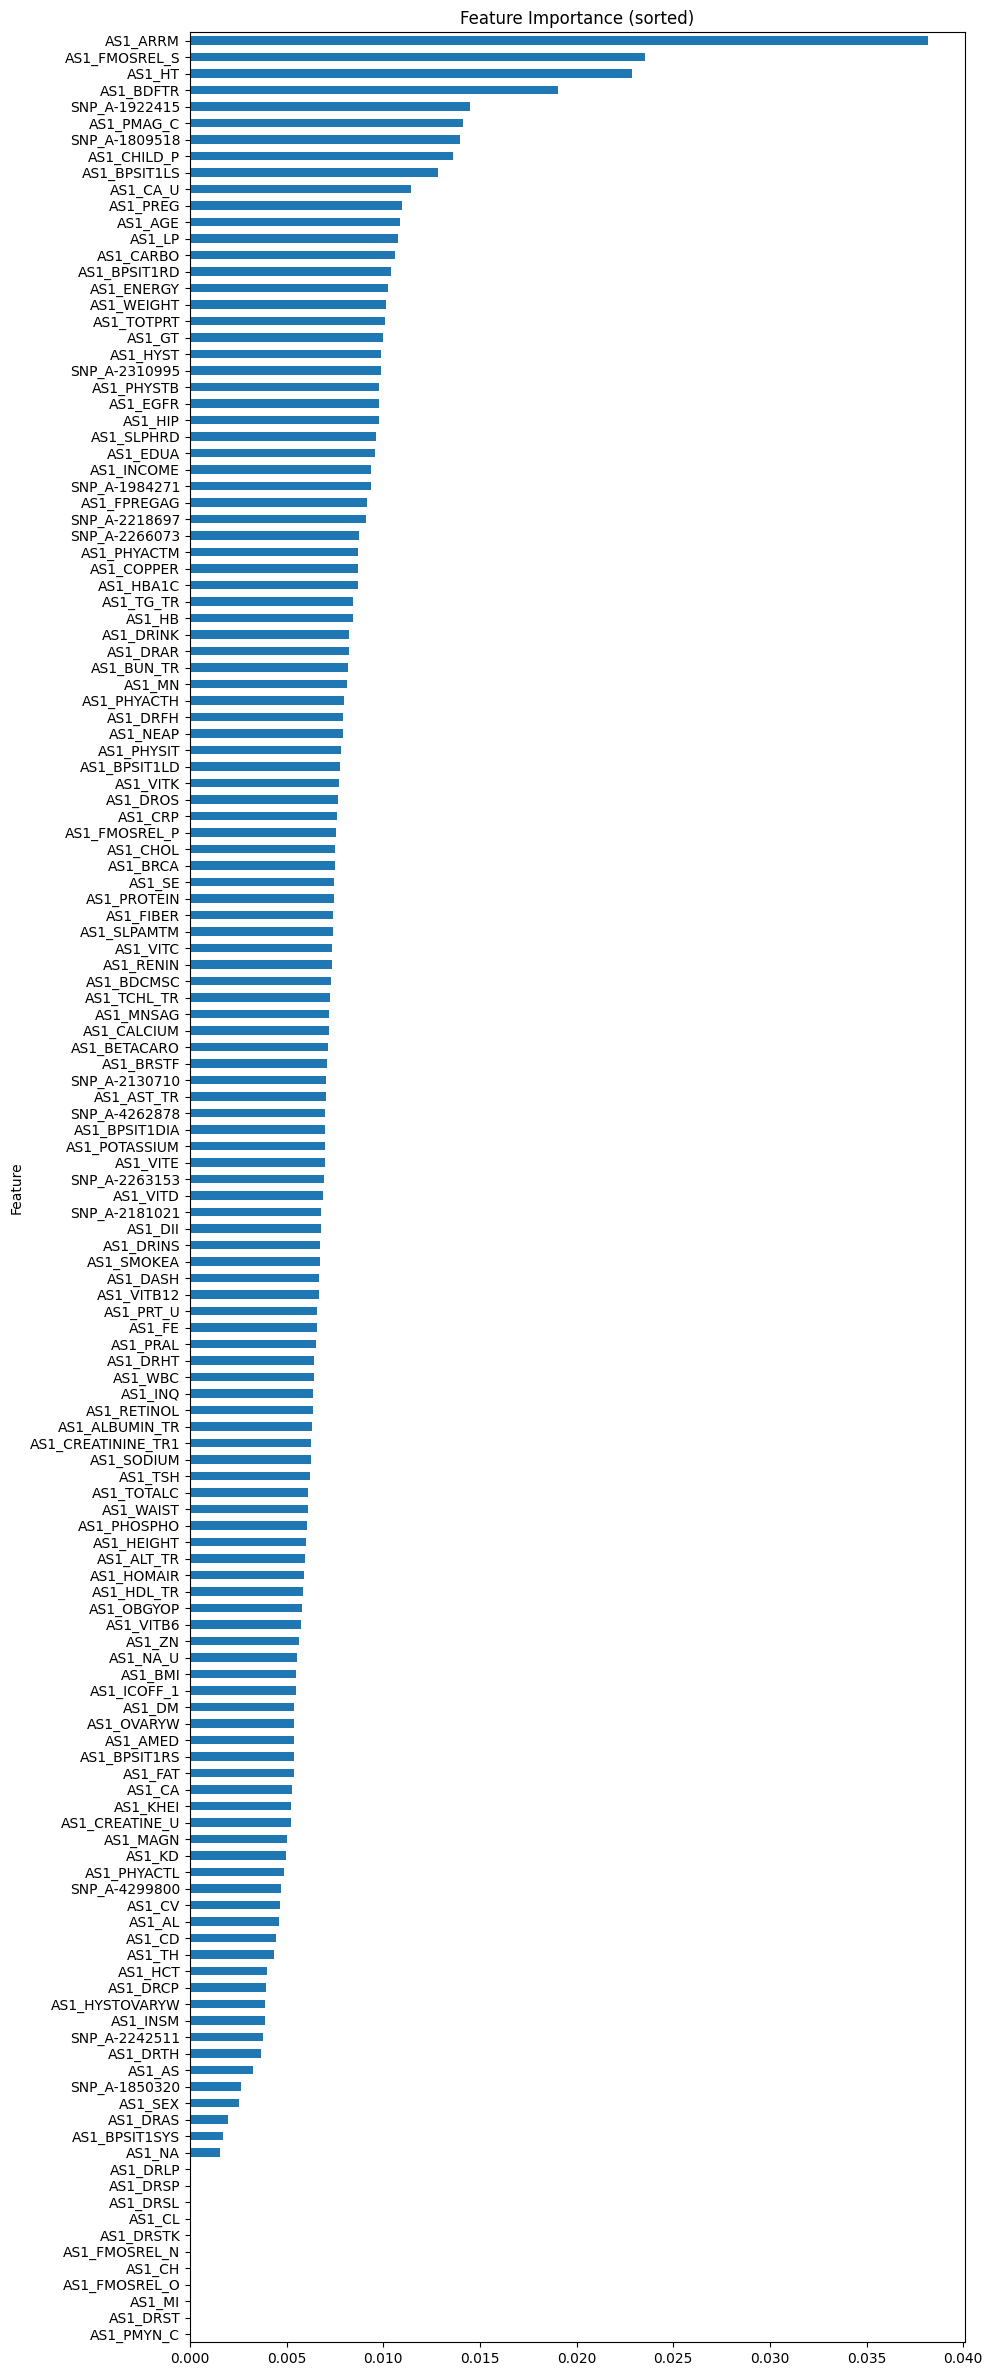

In [35]:
fig, ax = plt.subplots(figsize=(10, 30))
# tree_importances = pd.Series(tree_model.feature_importances_, index=X.columns).sort_values()
tree_importances = pd.Series(xgb.feature_importances_, index=X_train.columns).sort_values()
tree_importances.plot(kind="barh",
                      title="Feature Importance (sorted)",
                      ylabel="Feature" ,ax=ax)

In [36]:
cut_importances = tree_importances.iloc[-20:]
cut_importances

AS1_HYST         0.009873
AS1_GT           0.009998
AS1_TOTPRT       0.010084
AS1_WEIGHT       0.010143
AS1_ENERGY       0.010235
AS1_BPSIT1RD     0.010397
AS1_CARBO        0.010594
AS1_LP           0.010786
AS1_AGE          0.010885
AS1_PREG         0.010990
AS1_CA_U         0.011435
AS1_BPSIT1LS     0.012847
AS1_CHILD_P      0.013625
SNP_A-1809518    0.013976
AS1_PMAG_C       0.014113
SNP_A-1922415    0.014502
AS1_BDFTR        0.019050
AS1_HT           0.022881
AS1_FMOSREL_S    0.023556
AS1_ARRM         0.038178
dtype: float32

In [40]:
top20 = cut_importances.index.to_numpy()
top20

array(['AS1_HYST', 'AS1_GT', 'AS1_TOTPRT', 'AS1_WEIGHT', 'AS1_ENERGY',
       'AS1_BPSIT1RD', 'AS1_CARBO', 'AS1_LP', 'AS1_AGE', 'AS1_PREG',
       'AS1_CA_U', 'AS1_BPSIT1LS', 'AS1_CHILD_P', 'SNP_A-1809518',
       'AS1_PMAG_C', 'SNP_A-1922415', 'AS1_BDFTR', 'AS1_HT',
       'AS1_FMOSREL_S', 'AS1_ARRM'], dtype=object)

In [ ]:
SAMCGS(y_test, y_pred)

 Confusion Matrix:
[[316  53]
 [104  40]]

  [[TP  FN]
  [ FP  TN]]

  Accuracy: 0.694
  Precison: 0.430
  Recall  : 0.278
  F1 Score: 0.338


## LGBM

In [ ]:
# Create a LightGBM dataset
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)
val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)

# Set the hyperparameters
params = {
    'objective': 'binary',
    'metric': 'f1',  # You can use other metrics like 'binary_logloss' or 'auc'
    'boosting_type': 'gbdt',
    'num_leaves': 4,
    'learning_rate': 0.05,
    'feature_fraction': 0.9
}

# Train the model
num_round = 100
bst = lgb.train(params, train_data, num_round, valid_sets=[val_data])

[LightGBM] [Info] Number of positive: 1329, number of negative: 1329
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003919 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 30295
[LightGBM] [Info] Number of data points in the train set: 2658, number of used features: 134
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


In [ ]:
# Make predictions on the test set
y_pred = bst.predict(X_test, num_iteration=bst.best_iteration)
y_pred_binary = [1 if x > 0.5 else 0 for x in y_pred]
print("clf 전", np.unique(y_pred, return_counts=True))

# clf = lgb.LGBMClassifier()
# clf.fit(X_train, y_train) # LightGBMError: Do not support special JSON characters in feature name.
# y_pred=clf.predict(X_test)
# print("clf 후", np.unique(y_pred, return_counts=True))

clf 전 (array([0.16323587, 0.17470059, 0.17953912, 0.18018208, 0.18151356,
       0.18355899, 0.18545327, 0.18672352, 0.19642349, 0.1970919 ,
       0.19767509, 0.20001681, 0.20045747, 0.20200009, 0.20340797,
       0.20504634, 0.20660815, 0.21210692, 0.21276324, 0.21290881,
       0.21361144, 0.21613041, 0.22819327, 0.22975454, 0.23130696,
       0.23413309, 0.23500673, 0.23594747, 0.23680585, 0.23983975,
       0.24104586, 0.24155371, 0.24307712, 0.24563564, 0.24576798,
       0.2462662 , 0.24706125, 0.24878747, 0.24889968, 0.25067401,
       0.25105439, 0.25124805, 0.25287091, 0.2565017 , 0.25785253,
       0.25862658, 0.25867805, 0.25956261, 0.25967007, 0.26108749,
       0.26147545, 0.26261438, 0.26793443, 0.26868478, 0.26932897,
       0.27013326, 0.27036578, 0.2703877 , 0.27251767, 0.27342645,
       0.27396595, 0.27471738, 0.27545672, 0.27572367, 0.27820895,
       0.27854046, 0.28045454, 0.28051433, 0.28120931, 0.2819461 ,
       0.2829091 , 0.28469891, 0.28487475, 0.28827676, 

In [ ]:
SAMCGS(y_test, y_pred_binary)

 Confusion Matrix:
[[280  89]
 [ 89  55]]

  [[TP  FN]
  [ FP  TN]]

  Accuracy: 0.653
  Precison: 0.382
  Recall  : 0.382
  F1 Score: 0.382


In [ ]:
np.unique(y_val, return_counts=True)

(array([0, 1]), array([148, 148]))

## MLP

- 이전에 가장 좋았던 코드 사용
  - 고혈압 분석 모델 참고
  - hidden:
    - layer: 5
    - dimension: 32
  - output:
    - dimmension: 1
    - activation: Sigmoid

- 내가 할 코드
  - hidden:
    - layer:
    - dimension:
  - output:
    - dimmension:
    - activation: Sigmoid


In [ ]:
# torch의 Dataset 을 상속.
class TensorData(Dataset):

    def __init__(self, x_data, y_data):
        self.x_data = torch.FloatTensor(x_data)
        self.y_data = torch.FloatTensor(y_data)
        self.len = self.y_data.shape[0]

    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    def __len__(self):
        return self.len

In [ ]:
# 학습 데이터, 시험 데이터 배치 형태로 구축하기

train_sets = TensorData(X_train_tensor, y_train_tensor)
train_loader = torch.utils.data.DataLoader(train_sets, batch_size=32, shuffle=True)

test_sets = TensorData(X_test_tensor, y_test_tensor)
test_loader = torch.utils.data.DataLoader(test_sets, batch_size=32, shuffle=True)

validation_loader = TensorData(X_val_tensor, y_val_tensor)

In [ ]:
# input, hidden dim 매개변수로 따로 넣어주기

class Regressor(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__() # 모델 연산 정의
        self.fc1 = nn.Linear(input_dim, hidden_dim, bias=True) # 입력층() -> 은닉층1(50)으로 가는 연산
        self.dropout = nn.Dropout(0.05) # 연산이 될 때마다 5%의 비율로 랜덤하게 노드를 없앤다.
        self.fc2 = nn.Linear(hidden_dim, hidden_dim, bias=True) # 은닉층1(50) -> 은닉층2(30)으로 가는 연산
        self.dropout = nn.Dropout(0.05) # 연산이 될 때마다 5%의 비율로 랜덤하게 노드를 없앤다.
        self.fc3 = nn.Linear(hidden_dim, 1, bias=True) # 은닉층2(30) -> 출력층(1)으로 가는 연산
        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU()

    def forward(self, x): # 모델 연산의 순서를 정의
        x = self.fc1(x) # Linear 계산
        x = self.relu(x) # ReLu
        x = self.fc2(x) # Linear 계산 2
        x = self.relu(x) # ReLu
        x = self.fc3(x)
        x = self.sigmoid(x)

        # x = fn.relu(self.fc1(x)) # Linear 계산 후 활성화 함수 ReLU를 적용한다.
        # x = self.dropout(fn.relu(self.fc2(x))) # 은닉층2에서 드랍아웃을 적용한다.(즉, 30개의 20%인 6개의 노드가 계산에서 제외된다.)
        # x = fn.relu(self.fc3(x)) # Linear 계산 후 활성화 함수 ReLU를 적용한다.

        return x

# 주의 사항
# 드랍아웃은 과적합(overfitting)을 방지하기 위해 노드의 일부를 배제하고 계산하는 방식이기 때문에 절대로 출력층에 사용해서는 안 된다.

In [ ]:
mlp = Regressor(X_train.shape[1], 32)

In [ ]:
# criterion = nn.MSELoss() critation은 earlystopping을 사용할 때 쓰는 것.
objective = nn.BCELoss() # MSELoss에서 변경, 뒤 코드 주석 처리
optimizer = optim.Adam(mlp.parameters(), lr=0.001, weight_decay=1e-3)

In [ ]:
# loss_list = [] # loss를 저장할 리스트.
# n = len(trainloader)
# len_loader = len(train_loader)

for epoch in range(400):
  # running_loss = 0.0 # 한 에폭이 돌 때 그안에서 배치마다 loss가 나온다. 즉 한번 학습할 때 그렇게 쪼개지면서 loss가 다 나오니 MSE를 구하기 위해서 사용한다.

  for i, data in enumerate(train_loader, 0): # 무작위로 섞인 32개의 데이터가 담긴 배치가 하나씩 들어온다.
    inputs, values = data # data에는 X, Y가 들어있다.
    optimizer.zero_grad() # 최적화 초기화.
    outputs = mlp(inputs) # 모델에 입력값을 넣어 예측값을 산출한다.
    loss = objective(outputs, values) # 손실함수를 계산. error 계산.
    loss.backward() # 손실 함수를 기준으로 역전파를 설정한다.

    optimizer.step() # 역전파를 진행하고 가중치를 업데이트한다.

    # running_loss += loss.item() # epoch 마다 평균 loss를 계산하기 위해 배치 loss를 더한다.

  # loss_list.append(running_loss / len_loader) # MSE(Mean Squared Error) 계산

In [ ]:
# # model: mlp_premeno dataloader: premeno_train_loader
# def evaluation(model, dataloader):

#   predictions = torch.tensor([], dtype=torch.float) # 예측값을 저장하는 텐서.
#   actual = torch.tensor([], dtype=torch.float) # 실제값을 저장하는 텐서.

#   with torch.no_grad():
#     model.eval() # 평가를 할 땐 반드시 eval()을 사용해야 한다.

#     for data in dataloader:
#       inputs, values = data
#       outputs = model(inputs)

#       predictions = torch.cat((predictions, outputs), 0) # cat함수를 통해 예측값을 누적.
#       actual = torch.cat((actual, values), 0) # cat함수를 통해 실제값을 누적.

#   predictions = predictions.numpy() # 넘파이 배열로 변경.
#   actual = actual.numpy() # 넘파이 배열로 변경.

#   SAMCGS(actual.ravel().astype(np.float64), predictions.ravel().astype(np.float64))


In [ ]:
# train_rmse = evaluation(mlp_premeno, premeno_train_loader) # 원래는 이렇게 하면 안되지만, 비교를 위해서 train을 넣어서 본다.
# test_rmse = evaluation(mlp_premeno, premeno_test_loader)
# evaluation(mlp, test_loader)

In [ ]:
mlp.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for inputs, labels in validation_loader:  # Assuming you have a DataLoader for your validation data
        outputs = mlp(inputs)
        predictions = (outputs > 0.5).float()
        all_preds.extend(predictions.numpy())
        all_labels.extend(labels.numpy())

SAMCGS(all_labels, all_preds)

 Confusion Matrix:
[[245  50]
 [245  51]]

  [[TP  FN]
  [ FP  TN]]

  Accuracy: 0.501
  Precison: 0.505
  Recall  : 0.172
  F1 Score: 0.257
